In [1]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

Using TensorFlow backend.


In [0]:
# Training parameters
batch_size = 64  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

In [3]:
model_type = 'ResNet%dv%d' % (18, 1)
model_type

'ResNet18v1'

In [4]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    # if epoch > 180:
    #     lr *= 0.5e-3
    # elif epoch > 160:
    #     lr *= 1e-3
    # elif epoch > 120:
    #     lr *= 1e-2
    # elif epoch > 80:
    #     lr *= 1e-1
    
    lr = round(1e-3 * 1/(1 + 0.319 * (epoch//5)), 10)

    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 32
    stage 1: 32x32, 64
    stage 2: 16x16, 128
    stage 3:  8x8,  512
    # Arguments
        input_shape (tensor): shape of input image tensor
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    num_filters = 64
    num_res_blocks = 2
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(4):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 1 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                              num_filters=num_filters,
                              strides=strides)
            y = resnet_layer(inputs=y,
                              num_filters=num_filters,
                              activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
            # linear projection residual shortcut connection to match
            # changed dims
                x = resnet_layer(inputs=x,
                                  num_filters=num_filters,
                                  kernel_size=1,
                                  strides=strides,
                                  activation=None,
                                  batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
model = resnet_v1(input_shape=input_shape)

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

Learning rate:  0.001


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 64)   0           batch_normalization_1[0][0]      
____________________________________________________________________

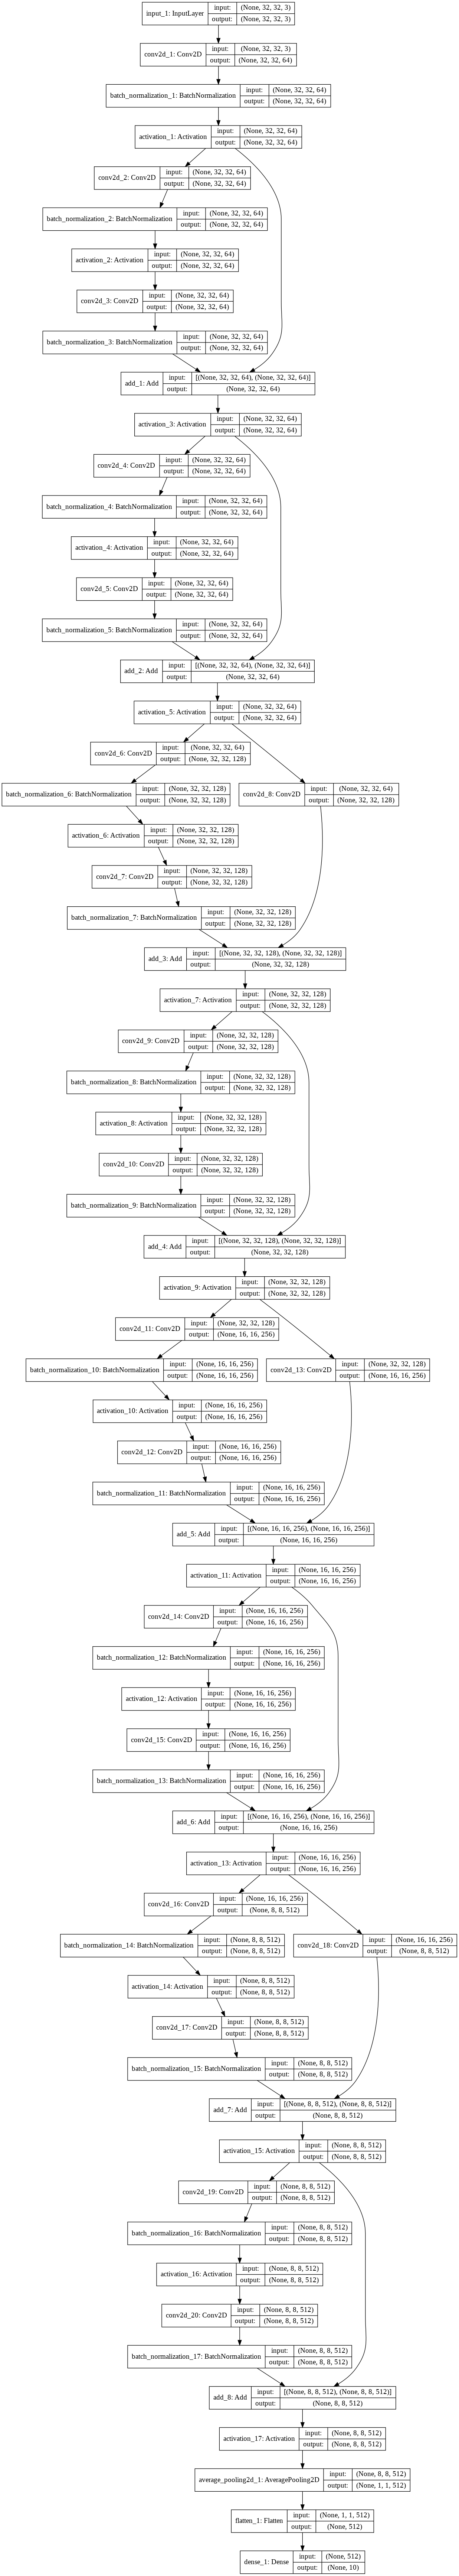

In [12]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:
print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

Using real-time data augmentation.


In [0]:
epochs=50
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          epochs=epochs, verbose=1, workers=8,
          validation_data=(x_test, y_test),
          callbacks=callbacks)

781/782 [============================>.] - ETA: 0s - loss: 0.2954 - acc: 0.9633

## GradCAM implementation

In [0]:
from keras.applications.vgg16 import preprocess_input#, decode_predictions
from keras.preprocessing import image
import numpy as np
import cv2
import keras.backend as K 
from skimage import io

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Download saved weights from drive and use them for GradCAM
model.load_weights("/content/drive/My Drive/Colab Notebooks/cifar10_ResNet18v1_model.036.h5")
model.summary()

In [40]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

[0.5228643430709838, 0.9051]


In [0]:
io.imread("https://gds-storage-prd.s3.amazonaws.com/unified-gallery/180724/1795/56aed032/thumbnails/aeroplane-2018-jul-20-02-08-40pm-000-customizedview26697263740-jpg-3500-3500.jpg")

In [0]:
## Model loaded successfully!

In [0]:
def fetch_img(URL):
  original = io.imread(URL)
  original = cv2.resize(original, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(original)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  x -= x_train_mean
  # print(x.shape)
  return original, x

In [0]:
def get_grads(model, x, l_name="add_8"):
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  # print("class Id: ", class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(l_name)

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  # print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  # print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, grads, last_conv_layer.output[0]])

  pooled_grads_value, grads_value, conv_layer_output_value = iterate([x])
  # print(grads_value.sum())
  # print("pooled_grads_value sum : ", pooled_grads_value.sum())

  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  # print("conv_layer_output_value sum: ", conv_layer_output_value.sum())
  return conv_layer_output_value

In [0]:
def show_images(conv_layer_output_value, original):
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  # print(conv_layer_output_value.shape)
  # print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  original = cv2.resize(original, (original.shape[1]*2, original.shape[0]*2))
  heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(original, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  print("Original:")
  cv2_imshow( original)
  print("GradCAM: ")
  cv2_imshow(superimposed_img)

Original:


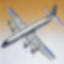

GradCAM: 


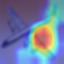

Original:


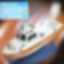

GradCAM: 


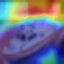

Original:


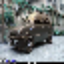

GradCAM: 


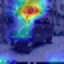

Original:


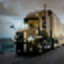

GradCAM: 


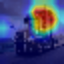

Original:


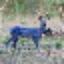

GradCAM: 


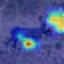

Original:


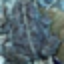

GradCAM: 


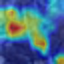

Original:


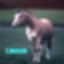

GradCAM: 


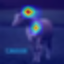

Original:


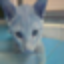

GradCAM: 


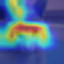

Original:


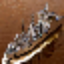

GradCAM: 


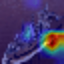

Original:


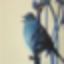

GradCAM: 


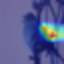

In [208]:
URLs = [
        "https://www.cs.toronto.edu/~kriz/cifar-10-sample/airplane4.png",
        "https://www.cs.toronto.edu/~kriz/cifar-10-sample/ship2.png",
        "https://www.team-bhp.com/forum/attachments/modifications-accessories/1599963d1485444999t-pics-tastefully-modified-cars-india-img20170121wa0028.jpg",
        "https://middleeast.macktrucks.com/-/media/images/hero-images/mack_hero_cards_mobile2.png",
        "https://upload.wikimedia.org/wikipedia/commons/e/ed/Siberian_roe_deer.jpg",
        "https://www.cs.toronto.edu/~kriz/cifar-10-sample/frog9.png",
        "https://www.cs.toronto.edu/~kriz/cifar-10-sample/horse7.png",
        "https://www.cs.toronto.edu/~kriz/cifar-10-sample/cat1.png",
        "https://img.theweek.in/content/dam/week/news/india/images/2019/10/11/ins-shakti-indian-navy.jpg",
        "https://www.cs.toronto.edu/~kriz/cifar-10-sample/bird4.png"

      ]

for i, url in enumerate(URLs):
  # print("Image {}".format(i))
  original, x = fetch_img(url)
  conv_layer_output_value = get_grads(model, x, l_name="add_8")
  show_images(conv_layer_output_value, original)